## Setup

In [ ]:
# Install required python packagesspike_recorder_soma
# !pip install -r ../requirements.txt

## Imports

In [1]:
import sys
import os
import warnings
import numpy as np

pkg_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(pkg_path)

np.set_printoptions(threshold=np.inf, suppress=True, linewidth=np.inf)
warnings.filterwarnings(action='ignore', category=UserWarning)

import neuroseq.addsrc
from neuroseq.common.config import *
from neuroseq.core.logging import log

In [2]:
RuntimeConfig.backend = Backends.NEST
RuntimeConfig.plasticity_location = PlasticityLocation.OFF_CHIP

In [3]:
shtm = None
offset = 0
if RuntimeConfig.backend == Backends.BRAIN_SCALES_2:
    from pynn_brainscales import brainscales2 as pynn
    from neuroseq.brainscales2.network import SHTMTotal
elif RuntimeConfig.backend == Backends.NEST:
    from neuroseq.nest.network import SHTMTotal
    
from neuroseq.common.network import NeuronType, RecTypes


Jan 30 18:07:23 Install [Info]: 
    loaded module PyNN extensions for NEST


## Configuration

In [4]:
# pynn.logger.default_config(level=pynn.logger.LogLevel.DEBUG)
# log.handlers[LogHandler.STREAM].setLevel(logging.DEBUG)

debug = False
external_input_binary = None

experiment_num = None

## Network Initialization

In [5]:
shtm = SHTMTotal()
shtm.init_backend(offset=0)

# FIXME: the timer only starts at start_time + period, fake calculation
# to get exactly one execution at the end of each runtime
if RuntimeConfig.plasticity_location == PlasticityLocation.ON_CHIP:
    shtm.init_plasticity_rule()
    finished_preprocessing = False

    while not finished_preprocessing:
        try:
            shtm.init_neurons()
        except HardwareError as e:
            log.error("Experienced Hardware error. Trying again.")
        else:
            finished_preprocessing = True
else:    
    shtm.init_neurons()

shtm.init_connections(debug=debug)
shtm.init_external_input()

if RuntimeConfig.backend == Backends.BRAIN_SCALES_2:
    shtm.init_rec_exc()
    
shtm.experiment_num = experiment_num

shtm.init_prerun()

log.info("Calibration done!")

Calibration done!


In [6]:
# RuntimeConfig.subnum_digits = 4
# shtm = SHTMTotal.load_full_state(network_type=SHTMTotal, experiment_id="eval", experiment_num=3, experiment_map="path-planning_02",
#                                  experiment_type=ExperimentType.EVAL_SINGLE)

## Network Emulation & Plotting

In [7]:
shtm.run(steps=50, plasticity_enabled=True)

Running predictive step 1/50
Performance:  1.0  |  Performance (0.5):  1.0  |  Epochs:  -1
Running predictive step 2/50
Performance:  1.0  |  Performance (0.5):  1.0  |  Epochs:  -1
Running predictive step 3/50
Performance:  1.0  |  Performance (0.5):  1.0  |  Epochs:  -1
Running predictive step 4/50
Performance:  1.0  |  Performance (0.5):  1.0  |  Epochs:  -1
Running predictive step 5/50
Performance:  0.82857  |  Performance (0.5):  0.94286  |  Epochs:  -1
Running predictive step 6/50
Performance:  0.82857  |  Performance (0.5):  0.88571  |  Epochs:  -1
Running predictive step 7/50
Performance:  0.82857  |  Performance (0.5):  0.87143  |  Epochs:  -1
Running predictive step 8/50
Performance:  0.41429  |  Performance (0.5):  0.725  |  Epochs:  -1
Running predictive step 9/50
Performance:  0.48571  |  Performance (0.5):  0.67714  |  Epochs:  -1
Running predictive step 10/50
Performance:  0.41429  |  Performance (0.5):  0.59429  |  Epochs:  -1
Running predictive step 11/50
Performance: 

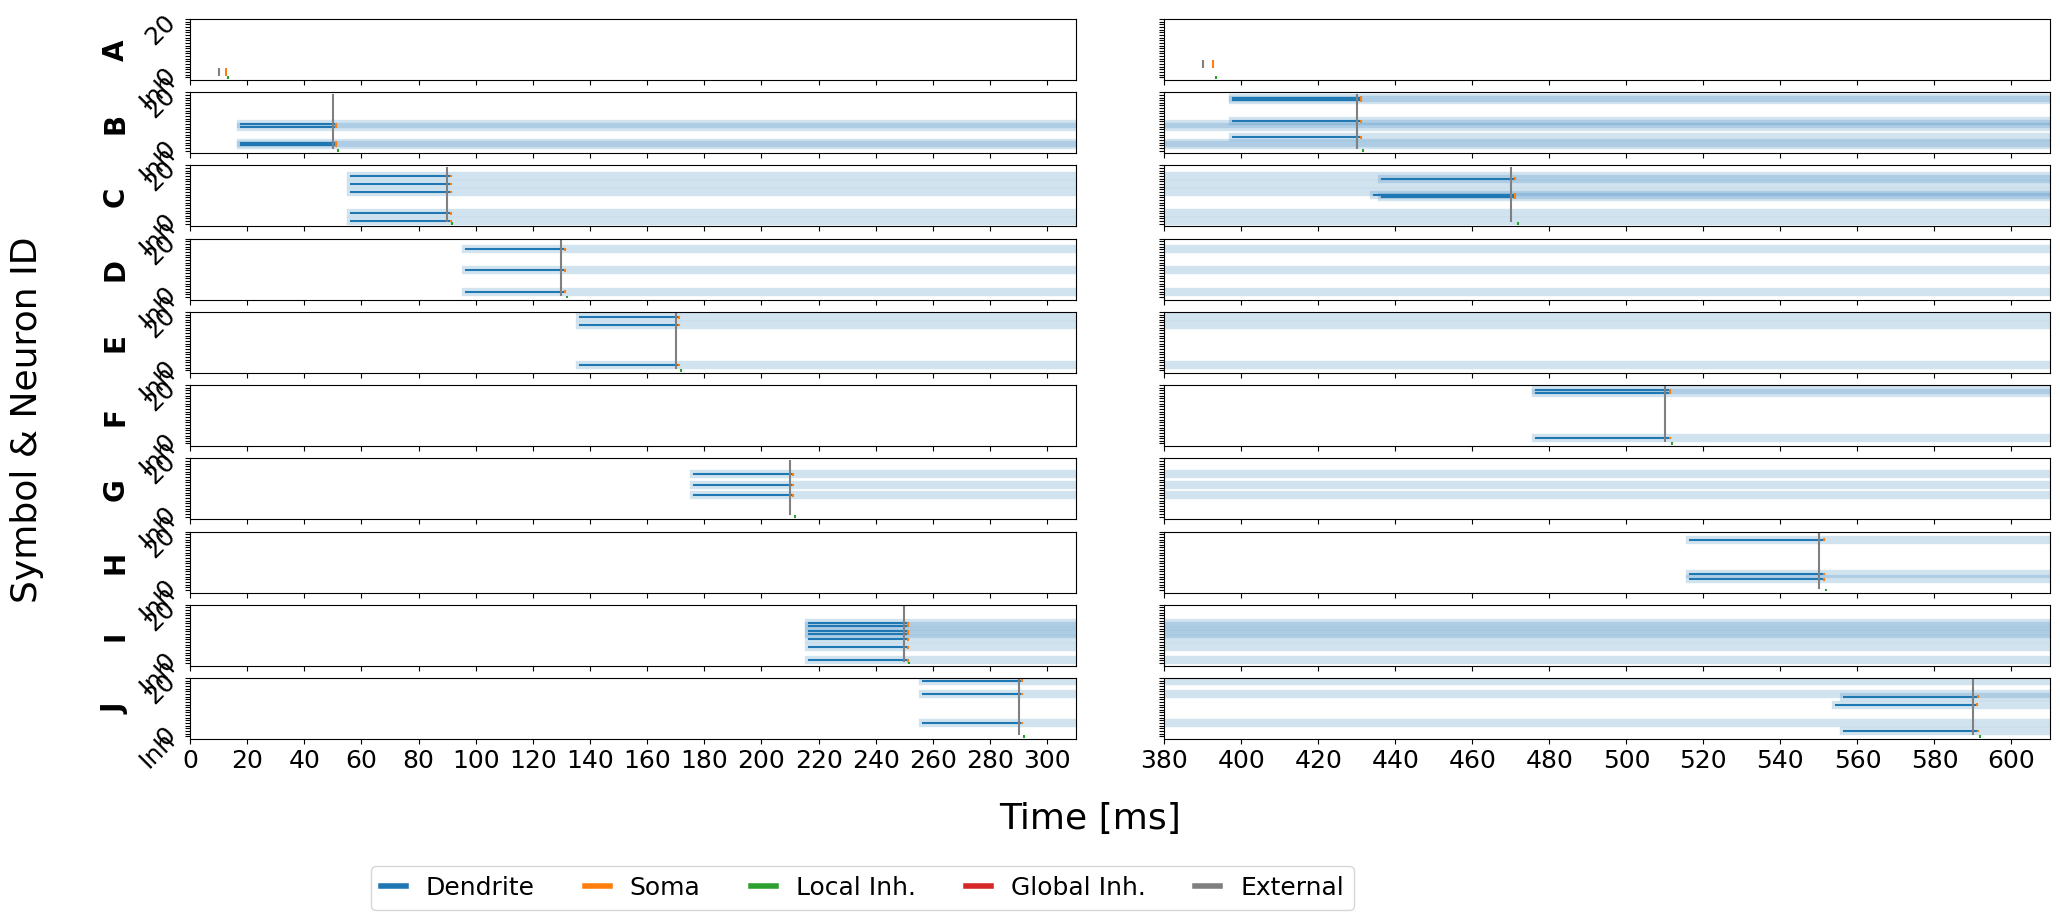

In [8]:
%matplotlib inline
from neuroseq.core.data import get_experiment_folder

shtm.plot_events(neuron_types="all", size=(24, 10), 
                 # run_id=0,
                 show_grid=False,
                 separate_seqs=True,
                 # x_lim_upper=1000
            )

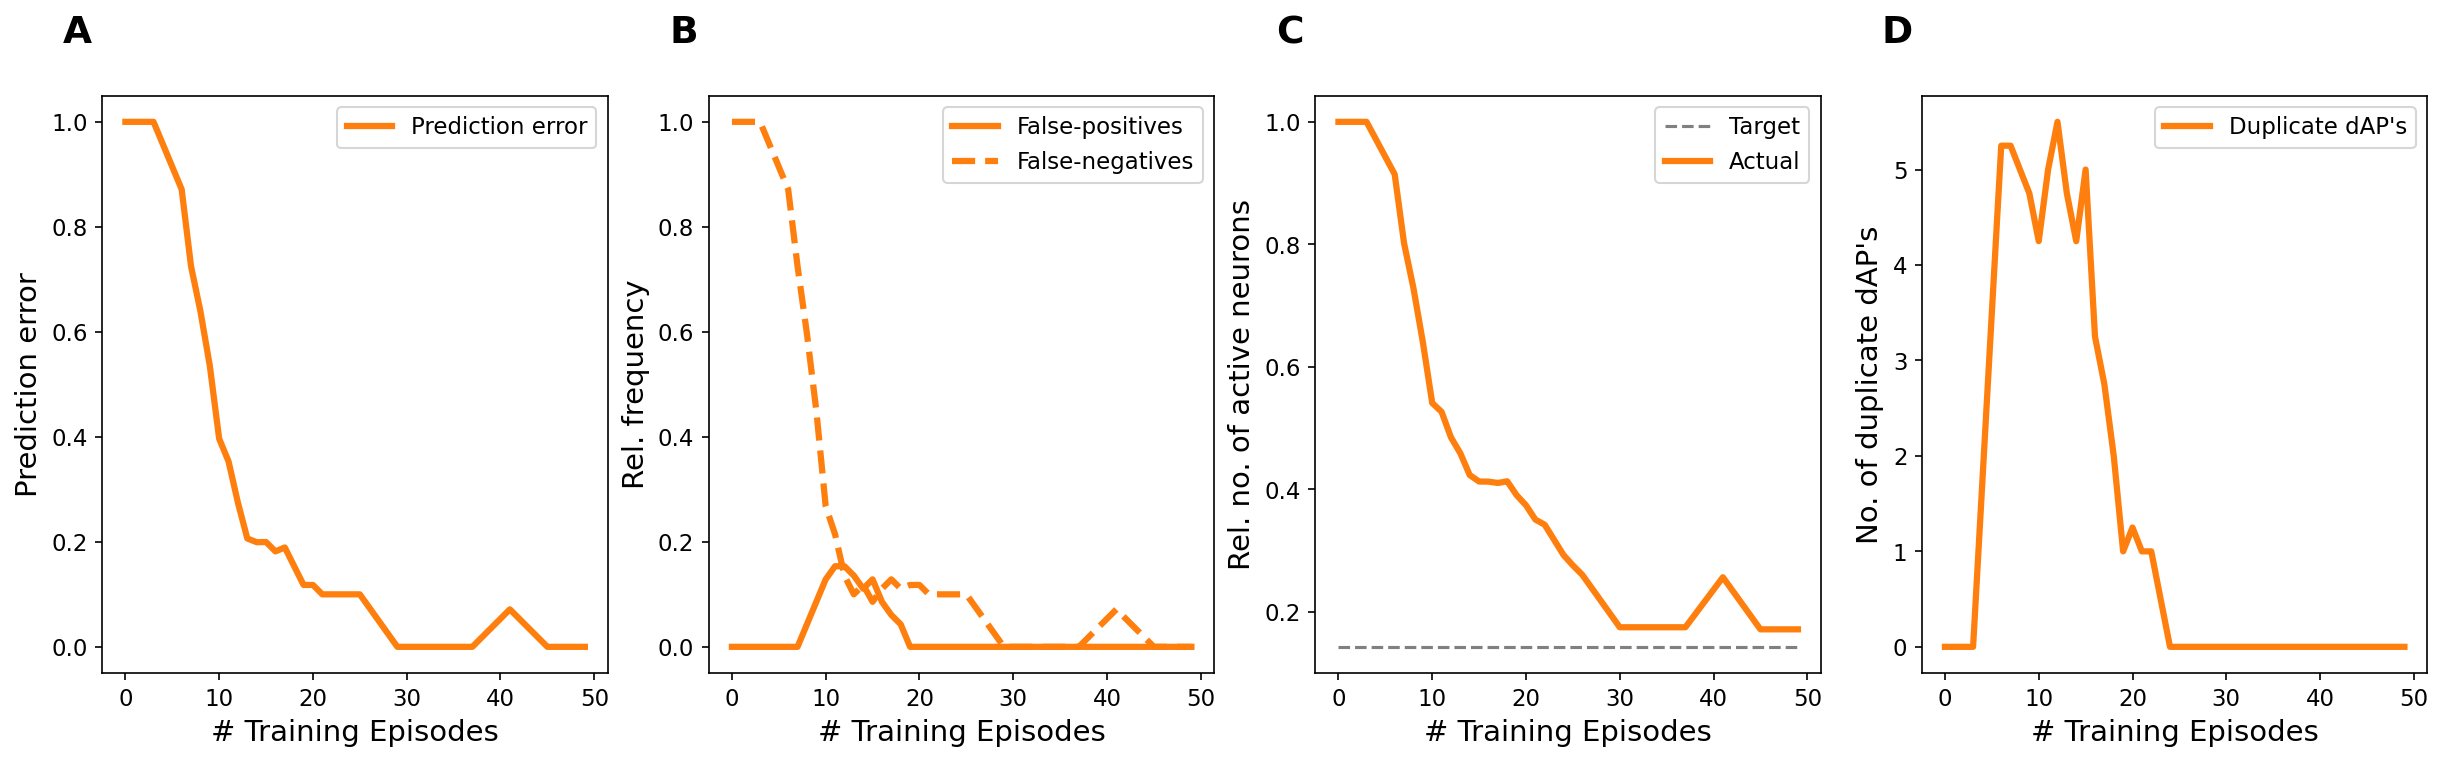

In [9]:
%matplotlib inline

shtm.plot_performance(StatisticalMetrics.MEAN, plot_dd=True)

In [20]:
shtm.save_full_state()

KeyboardInterrupt: 

In [11]:
# external_input_binary = [[np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]), np.zeros(12), np.zeros(12)]]
# shtm.init_external_input(init_recorder=False, init_performance=False, external_input_binary=external_input_binary)

'replay'

In [ ]:
from neuroseq.core.helpers import id_to_symbol


for i_sym in range(shtm.p.network.num_symbols):
    print(f"Symbol:  {id_to_symbol(i_sym)}")
    spikes = [s[0] for s in shtm.neuron_events[NeuronType.Soma][i_sym] if len(s) > 0 ]
    print(np.round(np.min(spikes), 2))

## Replay

In [5]:
shtm = SHTMTotal.load_full_state(network_type=SHTMTotal, 
                                 experiment_id="eval", 
                                 experiment_num=1, 
                                 experiment_map="ambiguous_03",
                                 # experiment_map="path-planning_02",
                                 experiment_type=ExperimentType.EVAL_SINGLE, 
                                 custom_params={
                                     # "replay.threshold_delta_t_up": 60,
                                     # "replay.max_scaling_loc": 0.3
                                                },
                                 network_mode=NetworkState.PREDICTIVE
                                 )

In [11]:
shtm.set_state(NetworkState.REPLAY, 
               # target=SYMBOLS['J']
               )

In [17]:
# shtm.neuron_thresholds_hist
# shtm.p.replay.threshold_delta_t_up = 60

9

In [13]:
%matplotlib inline

shtm.run(steps=2, plasticity_enabled=False, runtime=1200)
shtm.print_thresholds()

Running replay step 1/3
delta_t[H, J: [54.6]
delta_t[H, J: [54.6]
delta_t[H, J: [54.6]
Performance:  0.0  |  Performance (0.5):  0.01543  |  Epochs:  43
Running replay step 2/3
delta_t[F, H: [57.4]
delta_t[F, H: [57.4]
delta_t[H, J: [54.7]
delta_t[H, J: [54.8]
delta_t[H, J: [54.7]
Performance:  0.0  |  Performance (0.5):  0.01543  |  Epochs:  43
Running replay step 3/3
delta_t[C, F: [57.]
delta_t[F, H: [55.]
delta_t[F, H: [55.]
delta_t[H, J: [54.7]
delta_t[H, J: [54.8]
delta_t[H, J: [54.7]
Performance:  0.0  |  Performance (0.5):  0.01543  |  Epochs:  43


Membrane thresholds:
A: 6.5
B: 6.5
C: 5.8500000000000005
D: 6.5
E: 6.5
F: 5.265000000000001
G: 6.5
H: 4.738500000000001
I: 6.5
J: 5.2


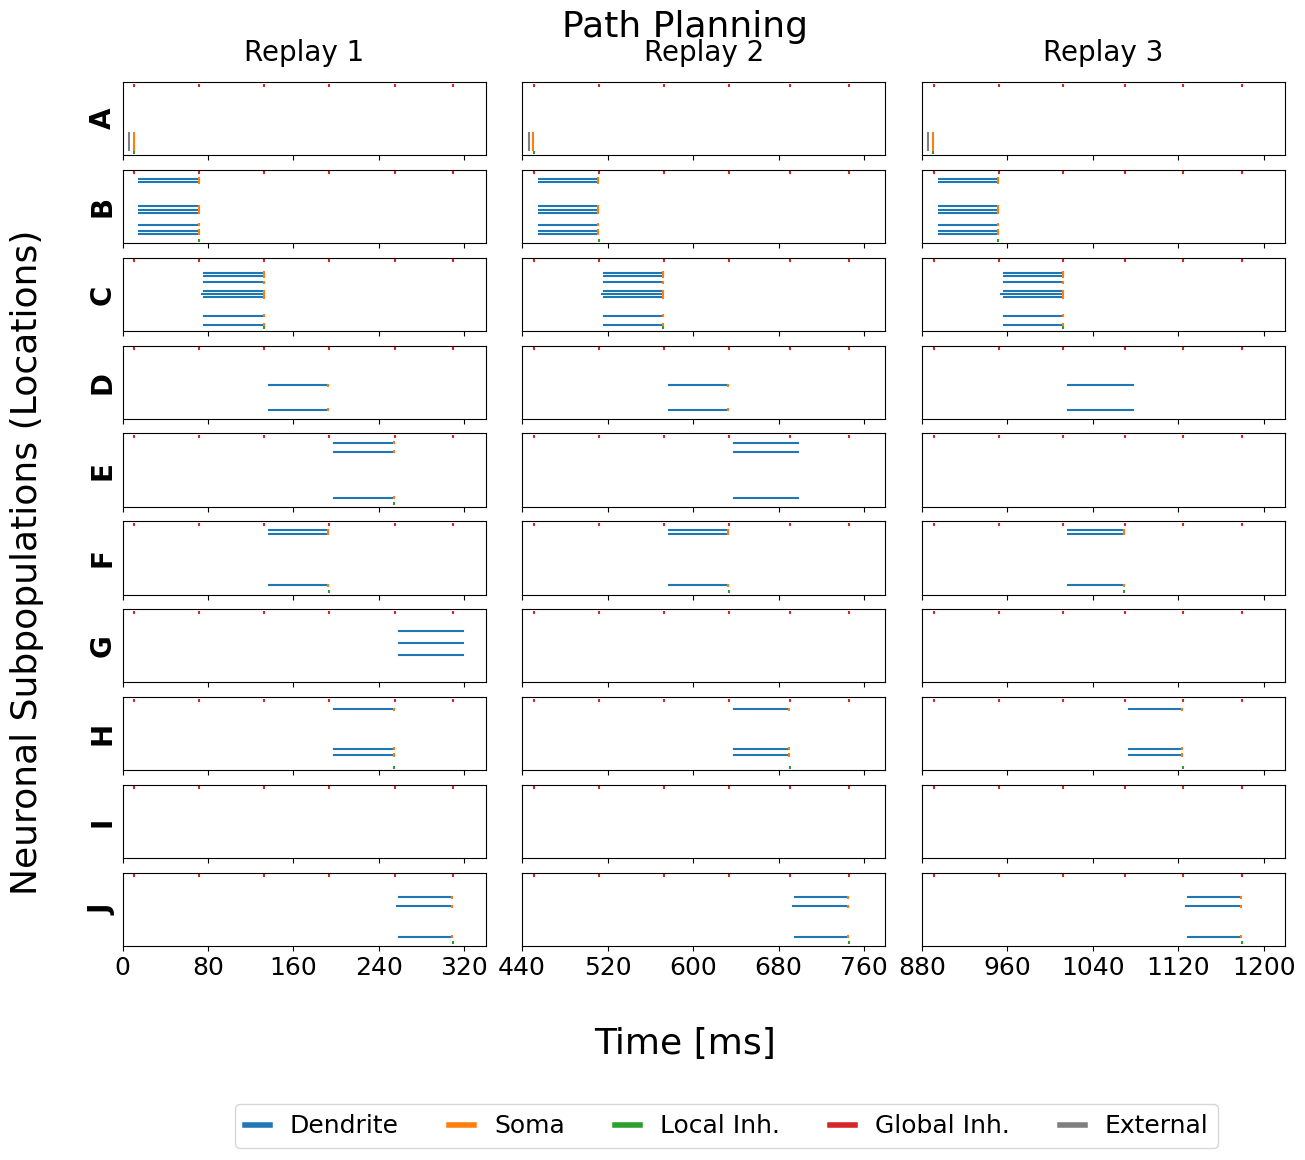

In [14]:
shtm.p_plot.load_default_params()

shtm.plot_events(neuron_types="all", size=(15, 12), 
                 # run_id=0,
                 show_grid=False,
                 separate_seqs=True,
                 # x_lim_upper=1200,
                 replay_runtime=200,
                 # replay_runtime=340,
                 plot_dendritic_trace=False,
                 enable_y_ticks=False,
                 x_tick_step=80,
                 fig_title="Path Planning",
                 plot_thresholds=False,
                # file_path="./eval_test"
            )

In [ ]:
shtm.p_plot.load_default_params()

shtm.plot_events(neuron_types="all", size=(15, 12), 
                 # run_id=0,
                 show_grid=False,
                 separate_seqs=True,
                 # x_lim_upper=1200,
                 replay_runtime=200,
                 # replay_runtime=340,
                 plot_dendritic_trace=False,
                 enable_y_ticks=False,
                 x_tick_step=80,
                 fig_title="Path Planning",
                 plot_thresholds=True,
                # file_path="./eval_test"
            )

In [ ]:
shtm.p_plot.load_default_params()

shtm.save_plot_events(self=shtm, neuron_types="all", size=(15, 12), 
                      # run_id=0,
                      show_grid=False,
                      separate_seqs=True,
                      # x_lim_upper=1200,
                      replay_runtime=200,     # ambiguous
                      # replay_runtime=340,       # path-planning
                      plot_dendritic_trace=False,
                      enable_y_ticks=False,
                      x_tick_step=80,
                      plot_thresholds=True,
                      # fig_title="Path Planning (A -> J)"
                      # fig_title="Place Disambiguation & Path Planning 1"
                      # fig_title="Place Disambiguation 1"
                      fig_title="Place Disambiguation 2a"
                      # fig_title="Place Disambiguation 2b"
                 
            )

In [ ]:
# shtm.map.plot_graph(arrows=True)
shtm.save_plot_graph()

# shtm.map.graph_history

In [ ]:
%matplotlib inline
from neuroseq.core.data import get_experiment_folder

shtm.plot_events(neuron_types="all", size=(6, 10), 
                 run_id=0,
                 show_grid=False,
                 separate_seqs=True,
            )

In [ ]:
%matplotlib inline
if RuntimeConfig.plasticity_location == PlasticityLocation.ON_CHIP:
    shtm.plot_data_overview()

In [ ]:
shtm.save_full_state()

## Plot performance

In [ ]:
%matplotlib inline

shtm.plot_performance(StatisticalMetrics.MEAN, plot_dd=True)

In [ ]:
%matplotlib inline

shtm.plot_permanence_history(plot_con_ids="all")

In [ ]:
# shtm.con_plastic[0].permanences[0]
shtm.exc_to_exc[0].get("weight", format="array")

## Second run

In [ ]:
shtm.run(steps=10, plasticity_enabled=True)

In [ ]:
%matplotlib inline

shtm.plot_events(neuron_types="all", size=(24, 10))

In [ ]:
%matplotlib inline

shtm.plot_performance()

In [ ]:
shtm.run(steps=10, plasticity_enabled=True)

In [ ]:
%matplotlib inline

shtm.plot_events(neuron_types="all", size=(24, 10))

In [ ]:
shtm.set_weights_exc_exc(10, 1, post_ids=[3,4,5], p_con=1.0)
shtm.run(steps=1, plasticity_enabled=True)

# %matplotlib inline
# shtm.plot_events(neuron_types="all", size=(24, 10))

## Additional Plotting

In [ ]:
%matplotlib inline

shtm.plot_permanence_diff()

In [ ]:
%matplotlib inline

# for i in [0, 1]:
#     print(shtm.con_plastic[i].permanences)

shtm.plot_permanence_history(plot_con_ids=[0, 1, 7])

In [ ]:
%matplotlib inline
from neuroseq.common.network import NeuronType, RecTypes

plot_v_exc(shtm, alphabet_range=[3], neuron_range="all", neuron_type=NeuronType.Soma, runtime=100)

In [ ]:
from tabulate import tabulate
import matplotlib.pyplot as plt
from neuroseq.core.helpers import id_to_symbol

def plot_v_exc(self, alphabet_range, neuron_range='all', size=None, neuron_type=NeuronType.Soma, runtime=None,
               show_legend=False, file_path=None):
    if size is None:
        size = (12, 10)

    if type(neuron_range) is str and neuron_range == 'all':
        neuron_range = range(self.p.network.num_neurons)
    elif type(neuron_range) is list or type(neuron_range) is range:
        pass
    else:
        return

    if type(runtime) is str:
        if str(runtime).lower() == 'max':
            runtime = self.last_ext_spike_time + (self.p.encoding.dt_seq - self.p.encoding.t_exc_start)
    elif type(runtime) is float or type(runtime) is int:
        pass
    else:
        runtime = self.p.experiment.runtime

    spike_times = [[]]
    header_spikes = list()

    fig, ax = plt.subplots(figsize=size)

    for alphabet_id in alphabet_range:
        # retrieve and save spike times
        spikes = self.neuron_events[neuron_type][alphabet_id]
        for neuron_id in neuron_range:
            # add spikes to list for printing
            spike_times[0].append(np.array(spikes[neuron_id]).round(5).tolist())
            header_spikes.append(f"{id_to_symbol(alphabet_id)}[{neuron_id}]")

            # retrieve voltage data
            data_v = self.get_neuron_data(neuron_type, value_type=RecTypes.V, symbol_id=alphabet_id,
                                          neuron_id=neuron_id, runtime=runtime)

            ax.plot(data_v.times, data_v, alpha=0.5, label=header_spikes[-1])

    # ax.xaxis.set_ticks(np.arange(0.02, 0.06, 0.01))
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

    ax.set_xlabel("Time [ms]", labelpad=14, fontsize=26)
    ax.set_ylabel("Membrane Voltage [a.u.]", labelpad=14, fontsize=26)
    
    ax.set_xlim(0, 100)

    if show_legend:
        plt.legend()

    # Print spike times
    print(tabulate(spike_times, headers=header_spikes) + '\n')

    fig.show()

    if file_path is not None:
        plt.savefig(f"{file_path}.pdf")

        pickle.dump(fig, open(f'{file_path}.fig.pickle',
                              'wb'))  # This is for Python 3 - py2 may need `file` instead of `open`

In [ ]:
%matplotlib inline

shtm.plot_v_exc(alphabet_range=[0], neuron_range='all', neuron_type=NeuronType.Dendrite, runtime=runtime, show_legend=False)

In [ ]:
%matplotlib inline

shtm.plot_v_exc(alphabet_range=range(1, alphabet_size))

## Additional Analysis

In [ ]:
for i in range(len(shtm.con_plastic)):
    shtm.con_plastic[i].mature_weight = 120
    print(i, shtm.con_plastic[i].projection.label.split('_')[1], shtm.con_plastic[i].get_all_connection_ids())
    

In [ ]:
arr = np.array(shtm.con_plastic[1].permanences)

In [ ]:
for c in shtm.con_plastic[1].projection.connections:
    print(f'C[{c.presynaptic_index}, {c.postsynaptic_index}].weight = {c.weight}')

In [ ]:
np.set_printoptions(threshold=np.inf, suppress=True, linewidth=np.inf)
shtm.con_plastic[1].projection.get("weight", format="array")

In [ ]:
shtm.con_plastic[7].projection.get("weight", format="array")

In [ ]:
# Print spikes form spiketrain
for s in shtm.con_plastic[1].projection.post.get_data("spikes").segments[-1].spiketrains:
    print(s)
print(len(shtm.con_plastic[1].projection.post.get_data("spikes").segments[-1].spiketrains))
print(len(shtm.con_plastic[1].projection.connections))

In [ ]:
for con in shtm.con_plastic:
    print(f"Sum(P[{con.projection.label}]) = {np.sum(con.permanences[-1] - con.permanences[0])}")

In [ ]:
dendrites, somas = shtm.get_spike_times(0.44, 0.1e-2)

print(somas)

In [ ]:
for i_plastic in range(len(shtm.con_plastic)):
    shtm.con_plastic[i_plastic].lambda_plus *= 2
    shtm.con_plastic[i_plastic].lambda_minus *= 2
    shtm.con_plastic[i_plastic].lambda_h *= 2
    
    # print(f"Sum(P[{con.projection.label}]) = {np.sum(con.permanences[-1] - con.permanences[0])}")

## Check indices

In [ ]:
dendrites, somas = shtm.neurons_exc[0]

print(somas.all_cells)
print(somas.id_to_index(13))

print(somas.get_data("spikes").segments[-1].spiketrains[8])
print(shtm.con_plastic[0].projection.pre.get_data("spikes").segments[-1].spiketrains[8])

## Check spikes

In [ ]:
dendrites, somas = shtm.neurons_exc[0]

spike_ids_a = list()
spike_ids_b = list()

# Print spikes form spiketrain
for s in somas.get_data("spikes").segments[-1].spiketrains:
    print(s)
    if len(s) > 0:
        print(s[0]/0.1e-3)
        spike_ids_a.append(int(s[0]/0.1e3))

    # for t in np.linspace(0., runtime, int(runtime / 0.1e-3)):
        
    
print(len(somas.get_data("spikes").segments[-1].spiketrains))



In [ ]:
print(shtm.neurons_exc[0][0].get("tau_m"))
print(shtm.neurons_inh[0].tau_m)
w = shtm.exc_to_inh[1].get("weight", format="array")
print(w)
print(pynn.get_current_time())

## Save objects

In [ ]:
import pickle

experiment_name = "shtm_off-chip_01"

with open(f'../evaluation/objects/{experiment_name}.pkl', 'wb') as out_file:
    pickle.dump(shtm, out_file)

In [ ]:
with open(f'../evaluation/objects/{experiment_name}.pkl', 'rb') as in_file:
    obj = pickle.load(in_file)

## Plotting - Events - All Symbols

In [ ]:
%matplotlib inline

seq = 2

fig_title = "Neuronal Events for Sequence {D, C, B} - After Learning"

file_path = f"../evaluation/figures/shtm-bss2_eval_learning-off-chip_seq-0{seq}_before-learning"
# file_path = f"../evaluation/figures/shtm-bss2_eval_learning-off-chip_seq-0{seq}_after-learning"

# file_path += "_a"

if seq == 1:
    fig = shtm.plot_events(shtm, size=[12, 10], x_lim_lower=0, x_lim_upper=0.14, seq_start=0.0, seq_end=0.14, fig_title=fig_title, file_path=file_path)
elif seq == 2:
    fig = shtm.plot_events(shtm, size=[12, 10], x_lim_lower=0.22, x_lim_upper=0.36, seq_start=0.22, seq_end=0.36, fig_title=fig_title, file_path=file_path)
    


## Plotting - Events - One Symbol

In [ ]:
%matplotlib inline

fig_title = "Neuronal Events for Sequence {D, C, B} - After Learning"
file_path = f"../evaluation/figures/shtm-bss2_eval_limits-spikes_w-inh"

# file_path += "_a"

fig = shtm.plot_events(shtm, neuron_types="all", symbols=[2], size=[12, 10], x_lim_lower=0, x_lim_upper=0.14, seq_start=0.0, seq_end=0.14, fig_title=fig_title, file_path=file_path)


spikes = shtm.neurons_exc[2][1].get_data("spikes").segments[-1].spiketrains

In [ ]:
# file_path_open = f"../evaluation/figures/shtm-bss2_eval_limits-volts_w-inh"
# file_path_open = f"../evaluation/figures/shtm-bss2_eval_limits-volts_wo-inh"
# file_path_open = f"../evaluation/figures/shtm-bss2_eval_limits-spikes_w-inh"
file_path_open = f"../evaluation/figures/shtm-bss2_eval_limits-spikes_wo-inh"

figx = pickle.load(open(f'{file_path_open}.fig.pickle', 'rb'))
figx.set_size_inches(12, 6)

figx.legends = []
figx.suptitle("")
figx.subplots_adjust(top=0.85)
neuron_types = [NeuronType.Dendrite, NeuronType.Soma, NeuronType.Inhibitory]
custom_lines = [Line2D([0], [0], color=f"C{n.ID}", label=n.NAME.capitalize(), lw=3) for n in neuron_types]
plt.figlegend(handles=custom_lines, loc=(0.402, 0.888), ncol=3, labelspacing=0., fontsize=18, fancybox=True, borderaxespad=1)


# figx.show()

figx.savefig(f"{file_path_open}.pdf", bbox_inches='tight')
# figx.savefig(f"{file_path_open}.png")

## Final Plots - Voltage

In [ ]:
%matplotlib inline

# plt.rcParams.update({'font.size': 12})

seq = 2

# file_path = f"../evaluation/figures/shtm-bss2_eval_learning-off-chip_seq-0{seq}_before-learning"
# file_path = f"../evaluation/figures/shtm-bss2_eval_learning-off-chip_seq-0{seq}_after-learning"
file_path = f"../evaluation/figures/shtm-bss2_eval_limits-volts_w-inh"

# file_path += "_a"

# if seq == 1:
    # fig = plot_v_exc(shtm, [0], neuron_range="all", size=[12, 10], x_lim_lower=0, x_lim_upper=0.14, seq_start=0.0, seq_end=0.14, file_path=file_path)
# elif seq == 2:
    # fig = plot_v_exc(shtm, [0], neuron_range="all", size=[12, 10], x_lim_lower=0.22, x_lim_upper=0.36, seq_start=0.22, seq_end=0.36, file_path=file_path)

shtm.plot_v_exc(shtm, [2], neuron_range="all", size=[12, 10], runtime=0.14, file_path=file_path)

    
